# Example-32: Orbit (quadruple shift)

In [1]:
# In this example effects of transverse quadrupole shifts on closed orbit are illustrated
# 1st order derivatives of closed orbit are computed
# Surrogate model from derivatives is compared with direct tracking

In [2]:
# Import

from pprint import pprint

import torch

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from twiss import twiss

from model.library.line import Line

from model.command.util import chop
from model.command.util import evaluate
from model.command.util import series

from model.command.external import load_lattice

from model.command.build import build

from model.command.wrapper import group

from model.command.orbit import orbit
from model.command.orbit import parametric_orbit

In [3]:
# Build and setup lattice

path = Path('ic.lte')
data = load_lattice(path)

ring:Line = build('RING', 'ELEGANT', data)
ring.propagate = True
ring.flatten()
ring.merge()
ring.split((None, ['BPM'], None, None))
ring.roll(1)
ring.splice()

In [4]:
# Compute closed orbit

fp = 1.0E-3*torch.randn(4, dtype=torch.float64)
fp, *_ = orbit(ring, fp, [], alignment=True, limit=8, epsilon=1.0E-12)

# Chop small values

fp = [fp]
chop(fp)
fp, *_ = fp

print(fp)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [5]:
# Compute parametric closed orbit

# Parametric orbit is computed separately for each plane
# Passing both goups together will result in computation of cross derivatives, i.e. d^2(qx, px, qy, py)/d(dx)d(dy)
# Also, since only the first order derivatives are computed, there is no interaction and they can be computed separatly for each element (selected name)

# Note, computation speed is moderate for 1st order derivatives
# Higher order derivatives computation time grows exponentially, so as grows memory requirements with torch.func.jacrev
# In memory limmited case, torch.func.jacfwd can be used, which requires less memory, but also much slower than torch.func.jacrev

n_quad = ring.describe['Quadrupole']

dx = torch.tensor(n_quad*[0.0], dtype=torch.float64)
dy = torch.tensor(n_quad*[0.0], dtype=torch.float64)

pox, *_ = parametric_orbit(ring,
                           fp,
                           [dx],
                           (1, 'dx', ['Quadrupole'], None, None),
                           alignment=True,
                           advance=True, 
                           full=False, 
                           jacobian=torch.func.jacrev)

poy, *_ = parametric_orbit(ring,
                           fp,
                           [dy],
                           (1, 'dy', ['Quadrupole'], None, None),
                           alignment=True,
                           advance=True, 
                           full=False, 
                           jacobian=torch.func.jacrev)

chop(pox)
chop(poy)

In [6]:
# Compute only for selected quadrupole (the first one)

name, *_ = [name for name, kind, *_ in ring.layout() if kind == 'Quadrupole']

# Adjust deviation variables 

dx = torch.tensor(1*[0.0], dtype=torch.float64)
dy = torch.tensor(1*[0.0], dtype=torch.float64)

# Compute d(qx,px,qy,py) / d(dx)

data, *_ = parametric_orbit(ring, fp, [dx], (1, 'dx', None, [name], None), alignment=True, advance=False)
chop(data)
pprint(data)
print()

# Compute d(qx,px,qy,py) / d(dy)

data, *_ = parametric_orbit(ring, fp, [dy], (1, 'dy', None, [name], None), alignment=True, advance=False)
chop(data)
pprint(data)
print()

# With two groups the following in computed

# d   (qx,px,qy,py) / d(dx)
# d   (qx,px,qy,py) / d(dy)
# d^2 (qx,px,qy,py) / d(dx)d(dy)

data, *_ = parametric_orbit(ring, fp, [dx, dy], (1, 'dx', None, [name], None), (1, 'dy', None, [name], None), alignment=True, advance=False)
chop(data)
pprint(data)
print()

[[tensor([0., 0., 0., 0.], dtype=torch.float64),
  tensor([[ 1.8121],
        [-2.6451],
        [ 0.0000],
        [ 0.0000]], dtype=torch.float64)]]

[[tensor([0., 0., 0., 0.], dtype=torch.float64),
  tensor([[  0.0000],
        [  0.0000],
        [ -5.5153],
        [-10.0840]], dtype=torch.float64)]]

[[[tensor([0., 0., 0., 0.], dtype=torch.float64),
   tensor([[  0.0000],
        [  0.0000],
        [ -5.5153],
        [-10.0840]], dtype=torch.float64)],
  [tensor([[ 1.8121],
        [-2.6451],
        [ 0.0000],
        [ 0.0000]], dtype=torch.float64),
   tensor([[[   0.0000]],

        [[   0.0000]],

        [[-378.9334]],

        [[-585.2541]]], dtype=torch.float64)]]]



In [7]:
# Compare with results for all quadrupoles

local, *_ = pox
pprint(local)
print()

local, *_ = poy
pprint(local)
print()

[[tensor([0., 0., 0., 0.], dtype=torch.float64),
  tensor([[  1.8121,  -0.7183,   5.5918,  -2.6908,  -1.4942,   0.3195,  -0.8425,
           2.7908,   1.4097,  -4.9412,   0.5832,  -2.2199,   4.1151,   4.3880,
          -2.5482,   0.2864,  -3.0901,  -1.1294,   4.8129,  -1.6948,  -0.6838,
           1.0844,  -4.6974,   6.1343,  -0.8751,   1.0602,  -2.4840,  -3.2927],
        [ -2.6451,   1.4732, -10.9761,   6.8781,   0.4980,   0.3000,   2.3551,
          -7.0806,  -0.3743,   7.6515,  -0.8327,   4.4808,  -8.0043,  -8.0279,
           4.5093,  -0.8070,   7.4910,  -0.1542,  -7.2558,   2.4290,   0.3869,
           0.2745,   7.0520, -11.1285,   1.5267,  -2.7711,   5.8554,   6.9226],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]

tensor([ 1.0330e-03, -2.0600e-03, -8.5705e-05, -5.3725e-04],
       dtype=torch.float64)
tensor([ 1.0330e-03, -2.0600e-03, -8.5705e-05, -5.3725e-04],
       dtype=torch.float64)
True

tensor([ 0.0010, -0.0020,  0.0000,  0.0000], dtype=torch.float64)
tensor([ 0.0000e+00,  0.0000e+00, -8.9063e-05, -5.4190e-04],
       dtype=torch.float64)



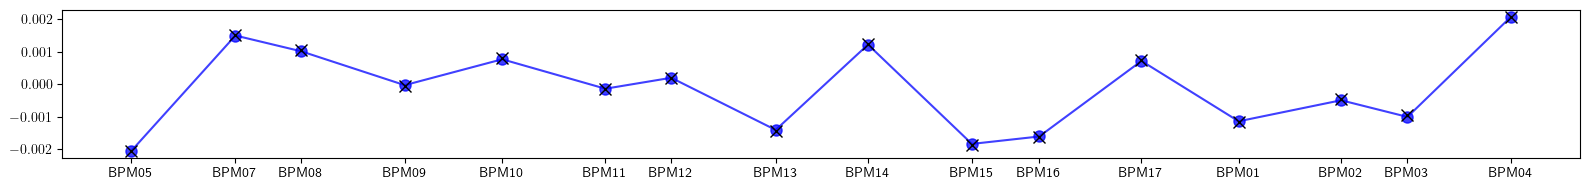

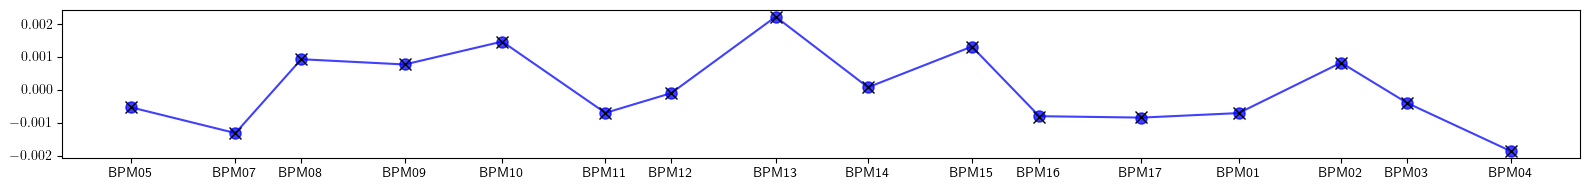

tensor([ 1.6464e-05,  1.1927e-05, -2.6803e-05,  1.7572e-05,  3.0857e-05,
        -1.9706e-05,  3.3654e-06,  2.0557e-05,  1.1557e-05, -2.4882e-05,
         1.7224e-05, -2.8642e-05, -1.6480e-05,  2.3818e-05, -2.5943e-05,
         5.2350e-06], dtype=torch.float64)

tensor([-2.0294e-05, -2.9471e-05, -4.3883e-05,  3.7667e-05, -4.6071e-05,
         2.2920e-05,  1.5767e-05,  3.0890e-05, -3.0656e-05,  4.0570e-05,
         3.0196e-05, -4.2305e-05,  3.5224e-05, -4.0320e-05, -4.5387e-05,
         2.0621e-05], dtype=torch.float64)

tensor([ 3.3573e-06,  2.4453e-07, -1.2019e-06,  3.9919e-06,  5.5643e-06,
        -6.7395e-08, -1.5772e-06, -3.8644e-06, -4.6883e-07,  2.0518e-06,
         3.9661e-06,  7.6349e-06,  1.8919e-06, -1.6691e-06, -7.2595e-07,
         2.4373e-06], dtype=torch.float64)

tensor([ 4.6486e-06, -1.7863e-06,  4.3081e-06, -1.7264e-06,  5.2059e-06,
        -2.0194e-06,  4.7156e-07,  6.3280e-06,  7.1448e-07,  4.2817e-06,
         1.1039e-05, -1.0053e-05, -3.0277e-06, -1.5325e-06,  3.06

In [8]:
# Compare orbit responce for a single random realization

# Set errors

dx = 50.0E-6*torch.randn(n_quad, dtype=torch.float64)
dy = 50.0E-6*torch.randn(n_quad, dtype=torch.float64)

# Compute closed orbit at all BPMs
# Note, alignment is on

points, *_ = orbit(ring, fp, [dx, dy], ('dx', ['Quadrupole'], None, None), ('dy', ['Quadrupole'], None, None), alignment=True, advance=True, full=False, limit=16, epsilon=1.0E-12)

# Test closed orbit

# Set parametric ring

start, *_, end = ring.names
mapping, *_ = group(ring, start, end, ('dx', ['Quadrupole'], None, None), ('dy', ['Quadrupole'], None, None), alignment=True)

# Propagate estimated closed orbit

point, *_ = points
print(point)
print(mapping(point, dx, dy))
print(torch.allclose(point, mapping(point, dx, dy), rtol=1.0E-12, atol=1.0E-12))
print()

# Evaluate parametric fixed point for given deviations

local, *_ = pox
print(evaluate(local, [fp, dx]))
local, *_ = poy
print(evaluate(local, [fp, dy]))
print()

# Plot orbit at all locations

qx, px, qy, py = points.T

Qx, Px, *_ = torch.stack([evaluate(local, [fp, dx]) for local in pox]).T
*_, Qy, Py = torch.stack([evaluate(local, [fp, dy]) for local in poy]).T

# qx vs Qx

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), qx.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), Qx.cpu().numpy(), fmt=' ', color='black', marker='x', ms=8, alpha=1)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

# px vs Px

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), px.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), Px.cpu().numpy(), fmt=' ', color='black', marker='x', ms=8, alpha=1)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

# qy vs Qy

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), qy.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), Qy.cpu().numpy(), fmt=' ', color='black', marker='x', ms=8, alpha=1)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

# py vs Py

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), py.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), Py.cpu().numpy(), fmt=' ', color='black', marker='x', ms=8, alpha=1)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

# Accuracy

print(qx - Qx)
print()

print(px - Px)
print()

print(qy - Qy)
print()

print(py - Py)
print()

In [9]:
# Estimate center and spread at all BPM using direct tracking and MC sampling
# Note, epsilon should be None for vmap, convergence not checked

def fn(dx, dy):
    guess = torch.tensor(4*[0.0], dtype=torch.float64)
    point, _ = orbit(ring, guess,  [dx, dy], ('dx', ['Quadrupole'], None, None), ('dy', ['Quadrupole'], None, None), alignment=True, advance=True, full=False, limit=16, epsilon=None)
    return point

dxs = 50.0E-6*torch.randn((8192, n_quad), dtype=torch.float64)
dys = 50.0E-6*torch.randn((8192, n_quad), dtype=torch.float64)

cqxs, cpxs, cqys, cpys = torch.vmap(fn)(dxs, dys).swapaxes(0, -1)

# Plot histogram at the first BPM for qx and qy

cqx, *_ = cqxs
cqy, *_ = cqys

fig, (ax, ay) = plt.subplots(1, 2, figsize=(12, 5))
ax.hist(cqx.cpu().numpy(), bins=100, range=(-5.0E-3, +5.0E-3), color='blue', alpha=0.7)
ay.hist(cqy.cpu().numpy(), bins=100, range=(-5.0E-3, +5.0E-3), color='blue', alpha=0.7)
plt.tight_layout() 
plt.show()

# Estimate center and spread at all BPMs

qx_center_tracking = cqxs.mean(-1)
qy_center_tracking = cqys.mean(-1)

qx_spread_tracking = cqxs.std(-1)
qy_spread_tracking = cqys.std(-1)

In [10]:
# Estimate spread (error propagation)

dx = torch.tensor(n_quad*[0.0], dtype=torch.float64)
dy = torch.tensor(n_quad*[0.0], dtype=torch.float64)

def fx(dx):    
    qx, px, qy, py = torch.stack([evaluate(local, [fp, dx]) for local in pox]).T
    return qx

def fy(dy):    
    qx, px, qy, py = torch.stack([evaluate(local, [fp, dy]) for local in poy]).T
    return qy

jx = torch.func.jacrev(fx)(dx)
jy = torch.func.jacrev(fy)(dy)

sx = 50.0E-6*torch.ones_like(dx)
sy = 50.0E-6*torch.ones_like(dy)

sx = torch.diag(sx**2)
sy = torch.diag(sy**2)

qx_spread_error = (jx @ sx @ jx.T).diag().sqrt()
qy_spread_error = (jy @ sy @ jy.T).diag().sqrt()

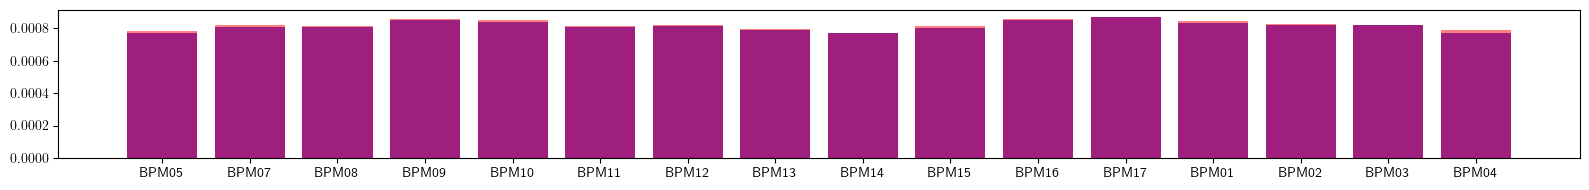

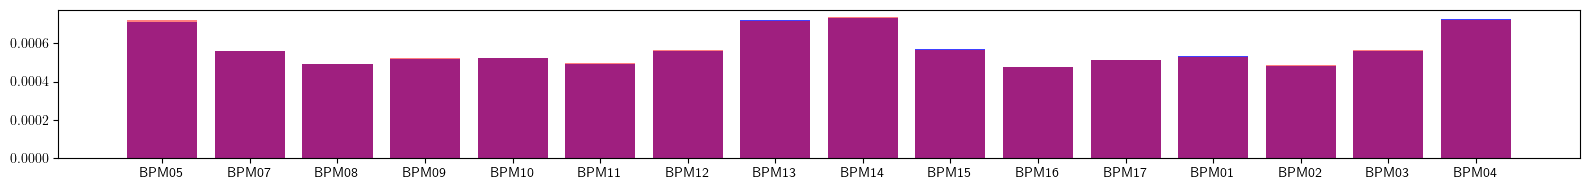

In [11]:
# Plot (compare estimated spreads)

plt.figure(figsize=(16, 2))
plt.bar(range(len(ring.locations())), qx_spread_tracking.cpu().numpy(), color='blue',alpha=0.75)
plt.bar(range(len(ring.locations())), qx_spread_error.cpu().numpy(), color='red', alpha=0.50)
plt.xticks(ticks=range(len(ring.locations())), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.bar(range(len(ring.locations())), qy_spread_tracking.cpu().numpy(), color='blue',alpha=0.75)
plt.bar(range(len(ring.locations())), qy_spread_error.cpu().numpy(), color='red', alpha=0.50)
plt.xticks(ticks=range(len(ring.locations())), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

In [12]:
# Estimate center and spread at all BPM using series and MC sampling

dxs = 50.0E-6*torch.randn((8192, n_quad), dtype=torch.float64)
dys = 50.0E-6*torch.randn((8192, n_quad), dtype=torch.float64)

cqxs, _, _, _ = torch.stack([torch.func.vmap(lambda dx: evaluate(local, [fp, dx]))(dxs) for local in pox]).swapaxes(0, -1)
_, _, cqys, _ = torch.stack([torch.func.vmap(lambda dy: evaluate(local, [fp, dy]))(dys) for local in poy]).swapaxes(0, -1)

# Plot histogram at the first BPM for qx and qy

cqx, *_ = cqxs.T
cqy, *_ = cqys.T

fig, (ax, ay) = plt.subplots(1, 2, figsize=(12, 5))
ax.hist(cqx.cpu().numpy(), bins=100, range=(-5.0E-3, +5.0E-3), color='blue', alpha=0.7)
ay.hist(cqy.cpu().numpy(), bins=100, range=(-5.0E-3, +5.0E-3), color='blue', alpha=0.7)
plt.tight_layout() 
plt.show()

# Estimate center and spread at all BPMs

qx_center_taylor = cqxs.T.mean(-1)
qy_center_taylor = cqys.T.mean(-1)

qx_spread_taylor = cqxs.T.std(-1)
qy_spread_taylor = cqys.T.std(-1)

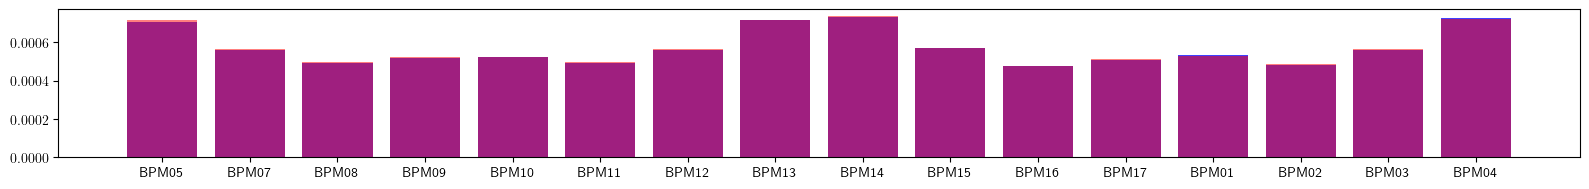

In [13]:
# Plot (compare estimated spreads)

plt.figure(figsize=(16, 2))
plt.bar(range(len(ring.locations())), qx_spread_tracking.cpu().numpy(), color='blue',alpha=0.75)
plt.bar(range(len(ring.locations())), qx_spread_taylor.cpu().numpy(), color='red', alpha=0.50)
plt.xticks(ticks=range(len(ring.locations())), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.bar(range(len(ring.locations())), qy_spread_tracking.cpu().numpy(), color='blue',alpha=0.75)
plt.bar(range(len(ring.locations())), qy_spread_taylor.cpu().numpy(), color='red', alpha=0.50)
plt.xticks(ticks=range(len(ring.locations())), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()